# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [45]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [7]:
path = Path('../../datasets/Ch13/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [8]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [9]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


## Tranform the data sets
### Windowing

In [10]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [13]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [14]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [15]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [16]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [17]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [18]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



### Split into X and Y (Features and Target)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [24]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [25]:
numpy_array = train_air.values
type(numpy_array)

numpy.ndarray

In [26]:
torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)

torch.Tensor

In [27]:
from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)

numpy.ndarray

In [28]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_pt(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_pt(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)

In [29]:
# returns a Tensor object
type(x_test_air)

torch.Tensor

In [30]:
y_train_air.shape

torch.Size([109, 1])

In [31]:
x_train_air.shape

torch.Size([109, 10, 1])

# RNN/LSTM in PyTorch

## RNN Model
* The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [34]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [35]:
issubclass(RNN, nn.Module)

True

In [36]:
issubclass(RNN, nn.RNN)

False

In [75]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

### Air Passenger

In [57]:
params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}

0/500 - Loss:  1.248458981513977, val_loss: 2.913243055343628
25/500 - Loss:  0.07549677789211273, val_loss: 0.370633989572525
50/500 - Loss:  0.04236747696995735, val_loss: 0.2115367203950882
75/500 - Loss:  0.03032415732741356, val_loss: 0.23759639263153076
100/500 - Loss:  0.023552851751446724, val_loss: 0.1965608149766922
125/500 - Loss:  0.022356674075126648, val_loss: 0.2015901356935501
150/500 - Loss:  0.02083197608590126, val_loss: 0.18952758610248566
175/500 - Loss:  0.02460547909140587, val_loss: 0.21788440644741058
200/500 - Loss:  0.01761906035244465, val_loss: 0.23224680125713348
225/500 - Loss:  0.01823282614350319, val_loss: 0.23066093027591705
250/500 - Loss:  0.023450031876564026, val_loss: 0.23033493757247925
275/500 - Loss:  0.019809110090136528, val_loss: 0.22515641152858734
300/500 - Loss:  0.01639980636537075, val_loss: 0.22069424390792847
325/500 - Loss:  0.016698233783245087, val_loss: 0.22635574638843536
350/500 - Loss:  0.01713731326162815, val_loss: 0.2309893

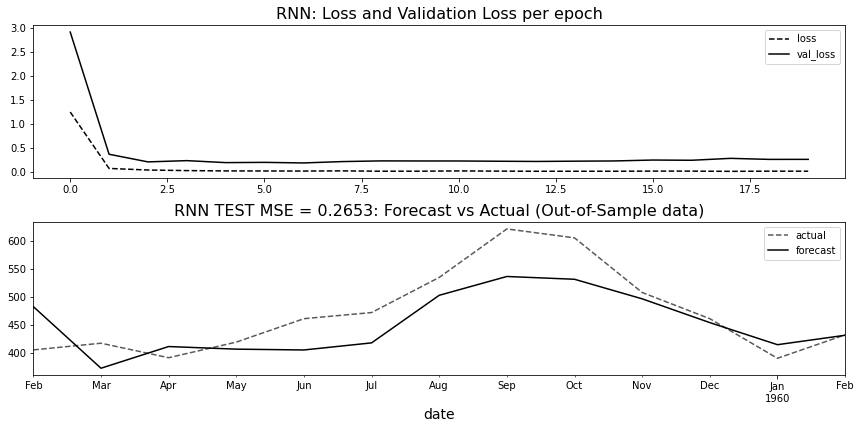

In [58]:
air_rnn, history_a_rnn = train_model_pt('RNN', **params_air)

### Avg Daily Temperature

0/500 - Loss:  1.107485294342041, val_loss: 0.7789257764816284
20/500 - Loss:  0.40858134627342224, val_loss: 0.3868982195854187
40/500 - Loss:  0.369635671377182, val_loss: 0.3408363163471222
60/500 - Loss:  0.33823883533477783, val_loss: 0.33403638005256653
80/500 - Loss:  0.3165019154548645, val_loss: 0.35715416073799133
100/500 - Loss:  0.2928943634033203, val_loss: 0.3333399295806885
120/500 - Loss:  0.27365678548812866, val_loss: 0.35701197385787964
140/500 - Loss:  0.2569712996482849, val_loss: 0.40610814094543457
160/500 - Loss:  0.24599498510360718, val_loss: 0.38759276270866394
180/500 - Loss:  0.22186605632305145, val_loss: 0.40434253215789795
200/500 - Loss:  0.2197209745645523, val_loss: 0.46140649914741516
220/500 - Loss:  0.21250320971012115, val_loss: 0.4310857951641083
240/500 - Loss:  0.20022554695606232, val_loss: 0.45978355407714844
260/500 - Loss:  0.19623981416225433, val_loss: 0.4502350986003876
280/500 - Loss:  0.18559108674526215, val_loss: 0.5043043494224548
3

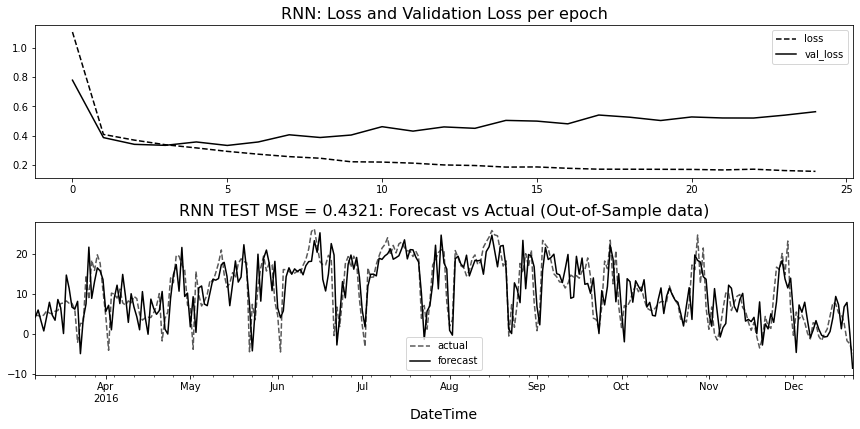

In [60]:
params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train_model_pt('RNN', **params_dw)

### Energy Consumption

0/500 - Loss:  1.0971441268920898, val_loss: 1.1394397020339966
20/500 - Loss:  0.11062125861644745, val_loss: 0.19054469466209412
40/500 - Loss:  0.0887998640537262, val_loss: 0.15520769357681274
60/500 - Loss:  0.07821086049079895, val_loss: 0.15604864060878754
80/500 - Loss:  0.06907683610916138, val_loss: 0.15328934788703918
100/500 - Loss:  0.06282529979944229, val_loss: 0.1533411145210266
120/500 - Loss:  0.052393995225429535, val_loss: 0.14745134115219116
140/500 - Loss:  0.04889164865016937, val_loss: 0.1511029303073883
160/500 - Loss:  0.048215802758932114, val_loss: 0.14490176737308502
180/500 - Loss:  0.051611725240945816, val_loss: 0.14588043093681335
200/500 - Loss:  0.04442991688847542, val_loss: 0.14806440472602844
220/500 - Loss:  0.04269333556294441, val_loss: 0.15448340773582458
240/500 - Loss:  0.043010421097278595, val_loss: 0.1589059680700302
260/500 - Loss:  0.04575645923614502, val_loss: 0.1559520810842514
280/500 - Loss:  0.04531436413526535, val_loss: 0.1536839

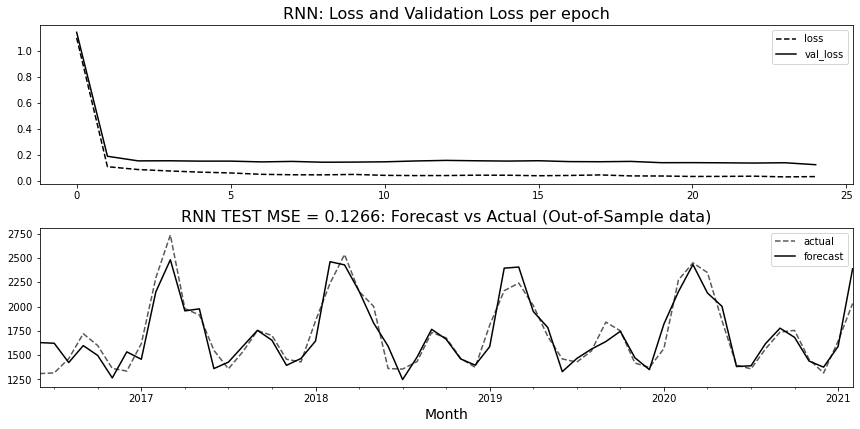

In [59]:
params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train_model_pt('RNN', **params_en)

## LSTM Model 
* The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

### Air Passenger

0/500 - Loss:  1.0304120779037476, val_loss: 2.6455042362213135
25/500 - Loss:  0.10421053320169449, val_loss: 0.451486736536026
50/500 - Loss:  0.04681143909692764, val_loss: 0.6328016519546509
75/500 - Loss:  0.03192973881959915, val_loss: 0.5040561556816101
100/500 - Loss:  0.028256503865122795, val_loss: 0.4348866045475006
125/500 - Loss:  0.02525067701935768, val_loss: 0.5552343130111694
150/500 - Loss:  0.025570081546902657, val_loss: 0.5913540720939636
175/500 - Loss:  0.02358720451593399, val_loss: 0.557668149471283
200/500 - Loss:  0.027891289442777634, val_loss: 0.6490574479103088
225/500 - Loss:  0.0199105404317379, val_loss: 0.6787160038948059
250/500 - Loss:  0.03044794499874115, val_loss: 0.6943133473396301
275/500 - Loss:  0.02392982691526413, val_loss: 0.5973120927810669
300/500 - Loss:  0.02670813351869583, val_loss: 0.5725447535514832
325/500 - Loss:  0.023948272690176964, val_loss: 0.41767778992652893
350/500 - Loss:  0.02210841327905655, val_loss: 0.4166231155395508

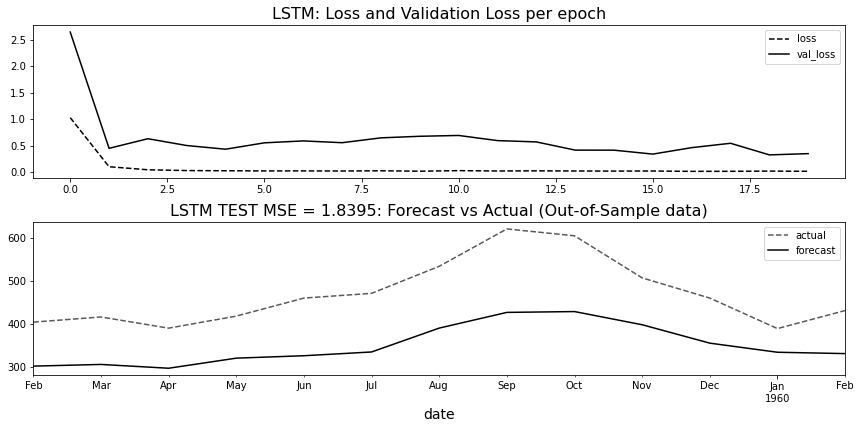

In [64]:
air_lstm, history_a_lstm = train_model_pt('LSTM', **params_air)

### Avg Daily Temperature

0/500 - Loss:  0.9987919330596924, val_loss: 0.7947289943695068
20/500 - Loss:  0.4197605550289154, val_loss: 0.362173467874527
40/500 - Loss:  0.34361112117767334, val_loss: 0.3305816650390625
60/500 - Loss:  0.3082190454006195, val_loss: 0.3146308362483978
80/500 - Loss:  0.2735999822616577, val_loss: 0.30971330404281616
100/500 - Loss:  0.2522682547569275, val_loss: 0.33698129653930664
120/500 - Loss:  0.22837594151496887, val_loss: 0.3388826549053192
140/500 - Loss:  0.1995634138584137, val_loss: 0.32979249954223633
160/500 - Loss:  0.19564537703990936, val_loss: 0.33023181557655334
180/500 - Loss:  0.17873191833496094, val_loss: 0.3528788089752197
200/500 - Loss:  0.17211438715457916, val_loss: 0.3734111189842224
220/500 - Loss:  0.16335545480251312, val_loss: 0.34876710176467896
240/500 - Loss:  0.16415205597877502, val_loss: 0.33709198236465454
260/500 - Loss:  0.148260697722435, val_loss: 0.37426114082336426
280/500 - Loss:  0.1462906301021576, val_loss: 0.347709059715271
300/5

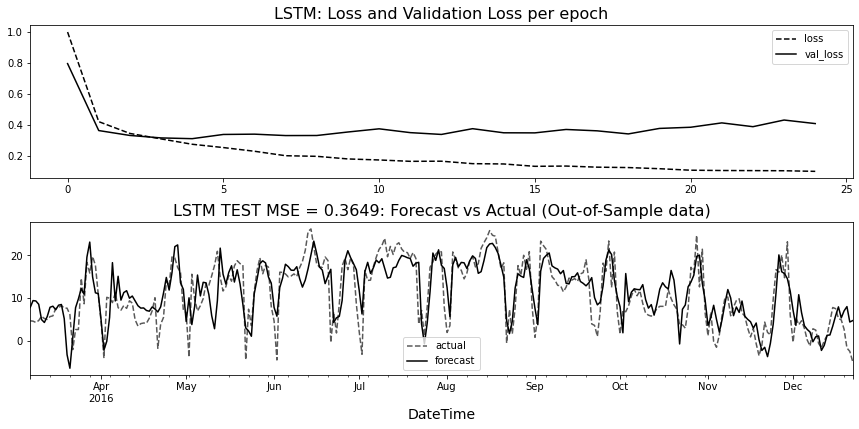

In [65]:
dw_lstm, history_dw_lstm = train_model_pt('LSTM', **params_dw)

### Energy Consumption

0/500 - Loss:  1.0093716382980347, val_loss: 1.2965831756591797
20/500 - Loss:  0.13084034621715546, val_loss: 0.25356975197792053
40/500 - Loss:  0.07827938348054886, val_loss: 0.18576064705848694
60/500 - Loss:  0.07303821295499802, val_loss: 0.1712721437215805
80/500 - Loss:  0.061602067202329636, val_loss: 0.1528581976890564
100/500 - Loss:  0.05922425538301468, val_loss: 0.14047738909721375
120/500 - Loss:  0.055909208953380585, val_loss: 0.13362939655780792
140/500 - Loss:  0.05087483674287796, val_loss: 0.13081412017345428
160/500 - Loss:  0.05037353187799454, val_loss: 0.12633100152015686
180/500 - Loss:  0.04484543949365616, val_loss: 0.12589558959007263
200/500 - Loss:  0.044101983308792114, val_loss: 0.1236085593700409
220/500 - Loss:  0.04422348365187645, val_loss: 0.12577073276042938
240/500 - Loss:  0.04280196130275726, val_loss: 0.12274131178855896
260/500 - Loss:  0.040827829390764236, val_loss: 0.12511374056339264
280/500 - Loss:  0.040402475744485855, val_loss: 0.1211

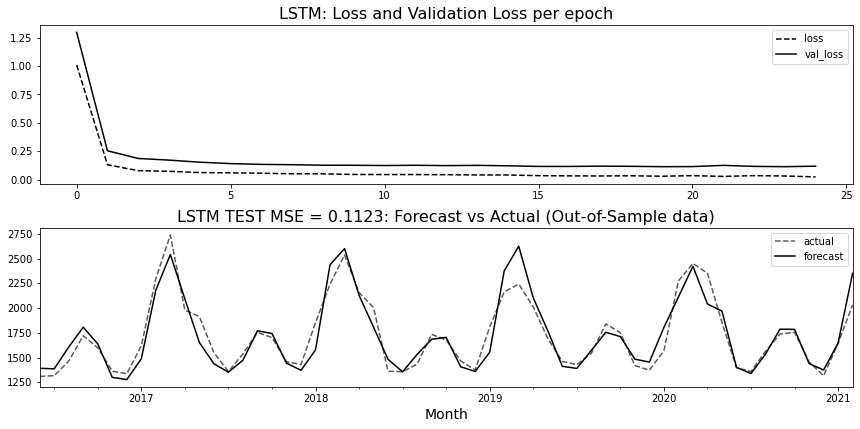

In [66]:
en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)

## LSTM with Dropout

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/500 - Loss:  1.068912386894226, val_loss: 1.1952530145645142
20/500 - Loss:  0.14449918270111084, val_loss: 0.2517915666103363
40/500 - Loss:  0.08813528716564178, val_loss: 0.1688016802072525
60/500 - Loss:  0.06676375865936279, val_loss: 0.155527263879776
80/500 - Loss:  0.06459834426641464, val_loss: 0.1463523954153061
100/500 - Loss:  0.05983957648277283, val_loss: 0.14801236987113953
120/500 - Loss:  0.049770187586545944, val_loss: 0.13650010526180267
140/500 - Loss:  0.05427122488617897, val_loss: 0.12765850126743317
160/500 - Loss:  0.04783596098423004, val_loss: 0.1320873647928238
180/500 - Loss:  0.045602329075336456, val_loss: 0.13481388986110687
200/500 - Loss:  0.03684813156723976, val_loss: 0.13500496745109558
220/500 - Loss:  0.04002055153250694, val_loss: 0.13600555062294006
240/500 - Loss:  0.03546435013413429, val_loss: 0.13630250096321106
260/500 - Loss:  0.03614409640431404, val_loss: 0.13782285153865814
280/500 - Loss:  0.03515922278165817, val_loss: 0.12969665229

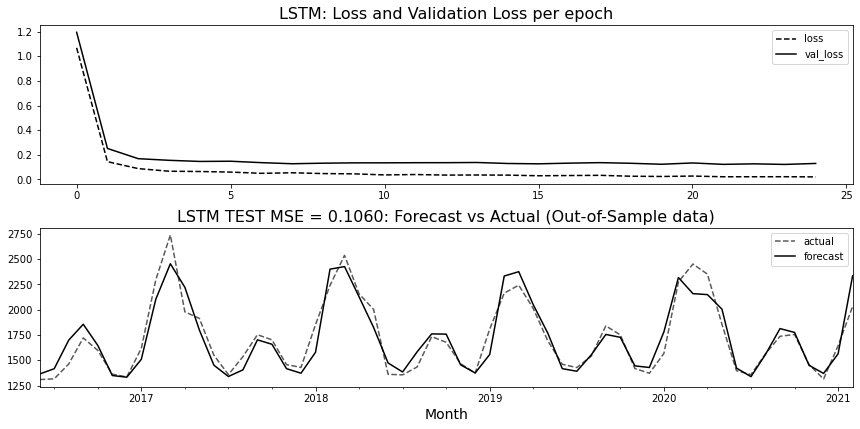

In [82]:
en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)

## GRU
* The math from the PyTorch GRU documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [93]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

### Air Passenger

0/500 - Loss:  0.8505772352218628, val_loss: 2.349889039993286
25/500 - Loss:  0.11129012703895569, val_loss: 0.35390472412109375
50/500 - Loss:  0.04151380434632301, val_loss: 0.36861178278923035
75/500 - Loss:  0.029574168846011162, val_loss: 0.2542467415332794
100/500 - Loss:  0.032170381397008896, val_loss: 0.3154587149620056
125/500 - Loss:  0.029741575941443443, val_loss: 0.4438003599643707
150/500 - Loss:  0.030580153688788414, val_loss: 0.5110482573509216
175/500 - Loss:  0.028088264167308807, val_loss: 0.38868626952171326
200/500 - Loss:  0.03114837035536766, val_loss: 0.45911625027656555
225/500 - Loss:  0.018999893218278885, val_loss: 0.4506641626358032
250/500 - Loss:  0.020721452310681343, val_loss: 0.36118626594543457
275/500 - Loss:  0.02059764415025711, val_loss: 0.46128401160240173
300/500 - Loss:  0.020420778542757034, val_loss: 0.3899040222167969
325/500 - Loss:  0.02379007078707218, val_loss: 0.33240628242492676
350/500 - Loss:  0.022159794345498085, val_loss: 0.283

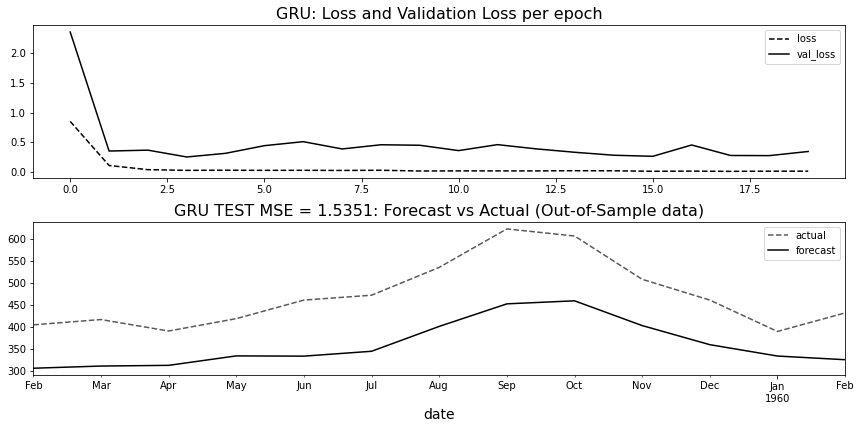

In [94]:
air_gru, history_a_gru = train_model_pt('GRU', **params_air)

### Avg Daily Temperature

0/500 - Loss:  0.9736660122871399, val_loss: 0.8081802725791931
20/500 - Loss:  0.41506731510162354, val_loss: 0.3676305115222931
40/500 - Loss:  0.33655500411987305, val_loss: 0.3383639454841614
60/500 - Loss:  0.2993752658367157, val_loss: 0.33795198798179626
80/500 - Loss:  0.2712436318397522, val_loss: 0.3157062828540802
100/500 - Loss:  0.2346087396144867, val_loss: 0.31674474477767944
120/500 - Loss:  0.21689443290233612, val_loss: 0.33934128284454346
140/500 - Loss:  0.19358406960964203, val_loss: 0.3626636564731598
160/500 - Loss:  0.18543276190757751, val_loss: 0.3960181176662445
180/500 - Loss:  0.1744937002658844, val_loss: 0.3845779299736023
200/500 - Loss:  0.18417277932167053, val_loss: 0.3359486162662506
220/500 - Loss:  0.17056135833263397, val_loss: 0.3822202682495117
240/500 - Loss:  0.15540717542171478, val_loss: 0.38920149207115173
260/500 - Loss:  0.14478111267089844, val_loss: 0.39640411734580994
280/500 - Loss:  0.13466066122055054, val_loss: 0.4382094442844391
3

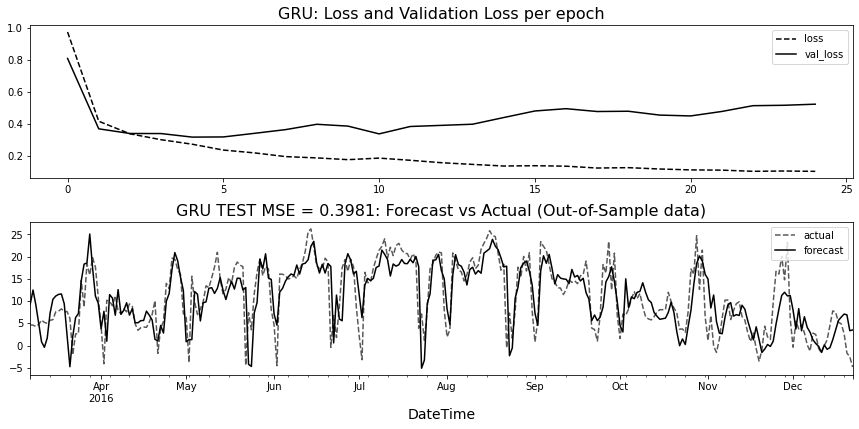

In [95]:
dw_gru, history_dw_gru = train_model_pt('GRU', **params_dw)

### Energy Consumption

0/500 - Loss:  0.9712182879447937, val_loss: 1.1754220724105835
20/500 - Loss:  0.12354632467031479, val_loss: 0.24085481464862823
40/500 - Loss:  0.07577105611562729, val_loss: 0.18661268055438995
60/500 - Loss:  0.07057084888219833, val_loss: 0.17091813683509827
80/500 - Loss:  0.061373885720968246, val_loss: 0.16312409937381744
100/500 - Loss:  0.059071432799100876, val_loss: 0.1503695696592331
120/500 - Loss:  0.051880475133657455, val_loss: 0.14623412489891052
140/500 - Loss:  0.05468223989009857, val_loss: 0.14164003729820251
160/500 - Loss:  0.05326036363840103, val_loss: 0.1421666443347931
180/500 - Loss:  0.0436256043612957, val_loss: 0.13484905660152435
200/500 - Loss:  0.04024013876914978, val_loss: 0.13217219710350037
220/500 - Loss:  0.04028068110346794, val_loss: 0.1295391023159027
240/500 - Loss:  0.03917388245463371, val_loss: 0.12916657328605652
260/500 - Loss:  0.034654222428798676, val_loss: 0.12624703347682953
280/500 - Loss:  0.03884194791316986, val_loss: 0.132874

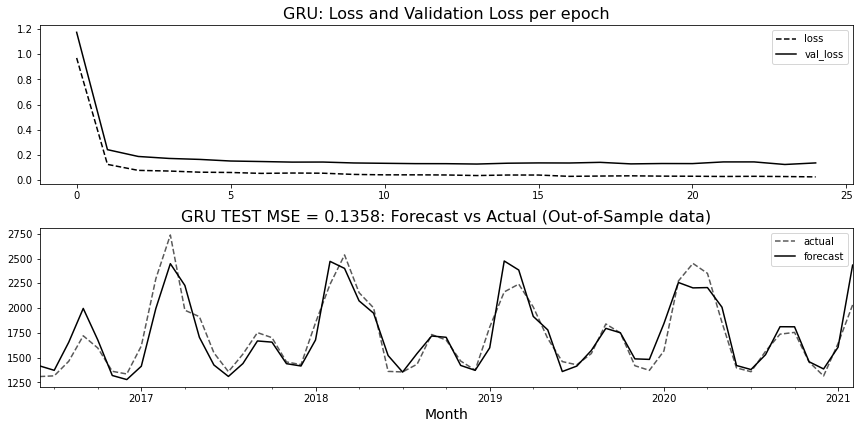

In [96]:
en_gru, history_en_gru = train_model_pt('GRU', **params_en)

## There is more

In [71]:
n_hidden = 32
input_size = x_train_en.shape[1]
n_layers = 1
output = 1

In [73]:
model_lstm_seq = torch.nn.Sequential(
    torch.nn.LSTM(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [97]:
model_gru_seq = torch.nn.Sequential(
    torch.nn.GRU(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [74]:
model_lstm_seq

Sequential(
  (0): LSTM(10, 32)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=32, out_features=1, bias=True)
)

In [84]:
en_gru.eval()

LSTM(
  (lstm): LSTM(10, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)